# Raw Strength

Lifting heavy things has been a human past time across many cultures. The Scots lifted heavy stones for sport, Icelandic fisherman used rocks of various size to determine whether a man could join their fishing boat, and the American Strongmen of the late 1800s lifted an assortment of weights in various, interesting ways. I personally love exercise and I thought this dataset would be fun for my first machine learning project. I think it will give me a chance to practice various data cleaning techniques and to implement feature engineering. My goal will be to practice classification by classifying lifters by gender with a 90% accuracy.

## Library Imports

In [24]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from matplotlib import pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

import pickle

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

## Exploratory Analysis

In [ ]:
df = pd.read_csv('openpowerlifting.csv')

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
# Check number of observations and features
df.shape

In [ ]:
# Check datatypes of all features
df.dtypes

In [ ]:
# Display grid of histograms
df.hist(figsize=(14, 14), xrot=315)

plt.show()

A lot of the lifts have negative values, which doesn't make sense as you can't lift a negative amount of weight. In this dataset, the negative values denote a missed lift. In a meet, these weights are simply discounted and do not affect lifting totals so I will change these values to 0.

In [ ]:
# Display summary statistics rounded to 3 decimals
df.describe()

Need to investigate age minimum value. I don't think anyone powerlifts at age 0...

In [ ]:
df.describe(include=['object'])

There are certainly missing values in this dataset. The fourth attempts for each lift are nearly empty so I will drop these columns. There are also a few features that probably won't be useful for my classification goal and that carry too many unique values. I will drop these for a cleaner and more useful dataset.

In [ ]:
df['Place'].unique()

I may drop rows where lifters were 'DQ', 'NS', 'DD', or 'G' and then drop the 'Place' column since there are so many unique values. Plus, the place a lifter got is based on their lifts and points, which are already part of the dataset.

In [ ]:
df.isnull().sum()

In [ ]:
# Ad-hoc data cleaning
df.drop(['Squat4Kg', 'Bench4Kg', 'Deadlift4Kg'], axis=1, inplace=True)

print( df.shape )

In [ ]:
# Visualize missing values
plt.figure(figsize=(14,14))

sns.heatmap(df.isnull())

Many rows are missing all 3 lift attempts. Should I remove these or denote them as missing?

In [ ]:
# Loop to plot categorical features to check for sparse classes
for feature in ['Sex', 'Event', 'Equipment', 'AgeClass']:
    sns.countplot(y=feature, data=df)
    plt.show()

Straps and Wraps can be grouped into raw because if a lifter used these but not single or multi-ply, then they must have been in a raw competition. I will also group multi-ply and single-ply into once class called Equipped. I will also only consider events that had all three lifts (SBD).

In [ ]:
# See unique values for WeightClassKg
# Should not be 124 different weightclasses

df['WeightClassKg'].unique()

I can group these into the standard weight classes for men and women used by the International Powerlifting Federation, or just drop this feature since the lifter's actual bodyweight is more important than their weightclass.

In [ ]:
# See why there are so many different divisions
df['Division'].unique()

Division seems to be synonymous with AgeClass. I may drop this since there are so many different divisions that it may not help the model.

In [ ]:
df['AgeClass'].unique()

There aren't too many different unique classes, but I may still drop this since we have a colunn for the lifter's age and that will be more useful than knowing the age class.

In [ ]:
# Segment totals by equipment used
plt.figure(figsize=(7,6))

sns.violinplot(y='Equipment', x='TotalKg', data=df)
plt.show()

In [ ]:
# Ad-hoc feature engineering: grouping sparse classes
df.Equipment.replace(['Wraps', 'Straps'], 'Raw', inplace=True)

df.Equipment.replace(['Single-ply', 'Multi-ply'], 'Equipped', inplace=True)

print(df.Equipment.unique())

In [ ]:
# Segment Equipment by TotalKg
plt.figure(figsize=(7,6))

sns.violinplot(y='Equipment', x='TotalKg', data=df)
plt.show()

Equipment seems to have some affect on the total amount of weight lifted, which makes sense given that the suits are made to help lifters lift more. Not a vast difference thought. There are also outliers that will need to be investigated and potentially removed. If there is nothing wrong with the data and it is just an unusually strong human, then the outliers will be kept.

In [ ]:
# Segment by Sex and display means of each class
df.groupby('Sex').mean()

A lot of third attempts seem to be missed, which makes sense because this is the attempt a lifter usually pushes their limits the farthest. Women seem to make their third deadlift attempt more often than men do. Men lift more in total on average.

In [ ]:
corr = df.corr()

sns.set_style('whitegrid')
plt.figure(figsize=(14,13))
sns.heatmap(corr,
            annot=True,
            cmap='RdBu_r',
            vmin=-1,
            vmax=1)
plt.show()

Correlations of lifts won't be accurate due to the negative numbers. I will need to check the correlations again after cleaning the data up a bit. But, some interesting things can still be seen like TotalKg and Best3SquatKg being almost completely correlated.

In feature engineering I should make a relative strength feature and plot a bivariate segmentation between male and female.

## Data Cleaning

In [ ]:
# Load dataframe and display first 5 observations
df = pd.read_csv('openpowerlifting.csv')

df.head()

In [ ]:
print( df.shape )

df.drop_duplicates(inplace=True)

print( df.shape )

In [ ]:
# Sum of missing values for each class
df.isnull().sum()

In [ ]:
# Drop rows where lifters did not place
df = df[df.Place != 'DQ']
df = df[df.Place != 'NS']
df = df[df.Place != 'DD']
df = df[df.Place != 'G']

In [ ]:
df.shape

In [ ]:
df.Place.unique()

I'll drop rows where all 3 lift attempts are missing. This will make the dataset more manageable for my laptop and will still leave me with plenty of useful data.

In [ ]:
# Drop rows where all 3 lift attempts for any lift are missing
df = df[df.Squat1Kg.notna() & df.Squat2Kg.notna() & df.Squat3Kg.notna()]
df = df[df.Bench1Kg.notna() & df.Bench2Kg.notna() & df.Bench3Kg.notna()]
df = df[df.Deadlift1Kg.notna() & df.Deadlift2Kg.notna() & df.Deadlift3Kg.notna()]


In [ ]:
df.shape

In [ ]:
# Drop unnecessary columns
df.drop(['Name', 'AgeClass', 'WeightClassKg', 'Division', 'Squat4Kg', 'Bench4Kg', 
         'Deadlift4Kg', 'Place', 'Country', 'Federation', 'Date',
         'MeetCountry', 'MeetState', 'MeetName'], axis=1, inplace=True)

In [ ]:
df.shape

In [ ]:
df.isnull().sum()

Lift attempts don't have missing values anymore, nor does TotalKg, but some of the best lift values are still missing a few.

In [ ]:
sns.countplot(y='Event', data=df)

Looks like dropping rows where all 3 attempts of one lift were missing took care of this. Let's go ahead and drop the event feature too since they are all the same event now.

In [ ]:
df.drop(['Event'], axis=1, inplace=True)

In [ ]:
df.Tested.unique()

In [ ]:
# Convert 'Tested' to indicator variable
df['Tested'] = (df.Tested == 'Yes').astype(int)

In [ ]:
df.Tested.unique()

In [ ]:
# Fill missing values in object columns with 'Missing'
for column in df.select_dtypes(include=['object']):
    df[column].fillna('Missing', inplace=True)

I want to make features that show when a lift was missed and the total number of missed lifts for each lifter, but I will need to do this before taking care of the missing data and the negative numbers.

In [ ]:
# Ad-hoc feature engineering for missed lifts
lifts = ['Squat1Kg', 'Squat2Kg', 'Squat3Kg',
         'Bench1Kg', 'Bench2Kg', 'Bench3Kg',
         'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg']

for lift in lifts:
    df[lift + '_missed'] = (df[lift] < 0).astype(int)
    
df.head()

In [ ]:
# Create Total_missed_lifts feature

df['Total_missed_lifts'] = df['Squat1Kg_missed'] + df['Squat2Kg_missed'] + df['Squat3Kg_missed'] + df['Bench1Kg_missed'] + df['Bench2Kg_missed'] + df['Bench3Kg_missed'] + df['Deadlift1Kg_missed'] + df['Deadlift2Kg_missed'] + df['Deadlift3Kg_missed']
        

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
# Plot correlations with cleaned data
correlations = df.corr()

mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = 1

sns.set_style('whitegrid')
plt.figure(figsize=(10,10))
sns.heatmap(correlations * 100,
            annot=True,
            cmap='RdBu_r',
            fmt = '.0f',
            mask=mask,
            cbar=False)
plt.show()

Total Kg is correlated with the bests from all 3 lifts. There are also strong correlations between the best lifts. Bodyweight is something that might be expected to be correlated with weight lifted, but it doesn't appear to have any strong correlations.

In [ ]:
# Flag best lifts when missing
best_lifts = ['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']

for lift in best_lifts:
    df[lift + '_missing'] = df[lift].isnull().astype(int)

In [ ]:
# Change negative numbers to nan
df.mask(df.select_dtypes(include=['float64']) < 0, other=np.nan, inplace=True)

In [ ]:
df.isnull().sum()

In [ ]:
# Change nan lifts to 0 to indicate a missed lift, which would result in a 0 score
lifts = ['Squat1Kg', 'Squat2Kg', 'Squat3Kg', 'Best3SquatKg',
         'Bench1Kg', 'Bench2Kg', 'Bench3Kg', 'Best3BenchKg',
         'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg', 'Best3DeadliftKg']

for lift in lifts:
    df[lift].fillna(0, inplace=True)

In [ ]:
df.isnull().sum()

In [ ]:
remaining_columns = ['Age', 'BodyweightKg', 'Wilks', 'McCulloch', 
                     'Glossbrenner', 'IPFPoints']

# Indicator variables for missingness in remaining columns
# 1 = missing, 0 = not missing
for column in remaining_columns:
    df[column + '_missing'] = df[column].isnull().astype(int)

In [ ]:
# Fill missing values in remaining numeric features with 0
for column in remaining_columns:
    df[column].fillna(0, inplace=True)

In [ ]:
df.head()

In [ ]:
df.isnull().sum()

In [ ]:
# Investigate outliers in lifts
for name in ['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg']:
    sns.violinplot(name, data=df)
    plt.show()

In [ ]:
df.TotalKg.sort_values(ascending=False).head()

In [ ]:
df[df.TotalKg == df.TotalKg.max()]

In the world of powerlifting, these outliers could very well be record setters and so are still important information. These outliers are hereby declared not guilty.

I'll now make a function that bundles together all of these data cleaning steps for use on any future data.

In [ ]:
df.to_csv('cleaned_openpowerlifting.csv', index=None)

## Feature Engineering

The Wilks and Glossbrenn coefficients attempt to calculate a best lifter across weight classes, while the McCulloch coefficient also takes into account the age of a lifter. The IPF also has a formula that awards points based on total weight lifted with respect to bodyweight. All of these coefficients have controversial biases. I will make a new feature that uses allometric scaling to score lifters across different weightclasses against each other. I got this idea from this article: https://www.strongerbyscience.com/whos-the-most-impressive-powerlifter/

In [ ]:
# Load cleaned dataframe
df = pd.read_csv('cleaned_openpowerlifting.csv')

df.head()

In [ ]:
df.shape

In [ ]:
# Feature engineering code from exploratory analysis
df.Equipment.replace(['Wraps', 'Straps'], 'Raw', inplace=True)

df.Equipment.replace(['Single-ply', 'Multi-ply'], 'Equipped', inplace=True)

In [ ]:
df['Allometric_relative_strength'] = df['TotalKg'] * (df['BodyweightKg']**(-2/3))

In [ ]:
df.Allometric_relative_strength.isnull().sum()

In [ ]:
df.Allometric_relative_strength.describe()

In [ ]:
df.Allometric_relative_strength.sort_values(ascending=False).head()

Why did some of these calculations result in infinity?

In [ ]:
df.iloc[[36321, 36322, 35327, 34923, 99281, 35109, 35110]]

In [ ]:
df.loc[df.Allometric_relative_strength == np.inf]

In [ ]:
df.loc[df.Allometric_relative_strength == np.inf].count()

It appears the infinite values are due to missing values in BodyweightKg. I'll make a feature that flags 'Allometric_relative_strength' as missing for inf values.

In [ ]:
# Convert infinite values to nan
df.Allometric_relative_strength.replace(np.inf, np.nan, inplace=True)

In [ ]:
df.loc[df.Allometric_relative_strength == np.inf].count()

In [ ]:
# Check to see if all inf were converted to nan
df.loc[df.Allometric_relative_strength.isnull()].count()

In [ ]:
# Create feature to flag missingness
df['Allometric_relative_strength_missing'] = df.Allometric_relative_strength.isnull().astype(int)

In [ ]:
# Unique values of new feature
df.Allometric_relative_strength_missing.unique()

In [ ]:
# Check that all missing values were converted to 1
df[df.Allometric_relative_strength_missing == 1].count()

In [ ]:
# Now replace nan with 0
df['Allometric_relative_strength'].fillna(0, inplace=True)

In [ ]:
df['Allometric_relative_strength'].isnull().sum()

In [ ]:
df.Allometric_relative_strength.max()

In [ ]:
# A bit more exploratory analysis - bivariate segmentation
sns.lmplot(x='TotalKg',
           y='Allometric_relative_strength',
           hue='Sex',
           data=df,
           fit_reg=False,
           scatter_kws={'alpha':0.1})
plt.show()

There is a linear relationship between the total weight lifted and relative strength, as would be expected.

In [ ]:
sns.lmplot(x='Allometric_relative_strength',
           y='Age',
           hue='Sex',
           data=df,
           fit_reg=False,
           scatter_kws={'alpha':0.01})
plt.show()

Age does have some affect on the relative strength ratings.

In [ ]:
# Convert target variable 'Sex' to an indicator variable
df['Sex'] = pd.get_dummies(df.Sex).M

In [ ]:
# Proportion of lifters who are male
df.Sex.mean()

In [ ]:
df.dtypes

In [ ]:
# Create new DataFrame with dummy features
df = pd.get_dummies(df, columns=['Equipment'])

df.head(10)

I'll now make a function that bundles together all of the feature engineering steps.

In [ ]:
df.to_csv('analytical_base_table.csv', index=None)

## Algorithm Selection

The task is binary classification and I will cross-validate 4 algorithms and then compare their AUROC scores. The algorithms I will test Logistic Regression (L1 and L2-regularized), Random Forest Classification and Gradient Boosting Classification. Logistic Regression is a common and fairly simple algorithm for binary classification. The L1 penalizes the absolute size of model coefficients whereas L2 penalizes the squared size. Random Forests and Gradient Boosting are more complex and robust algorithms, but in turn may be more prone to overfitting. With Random Forests I will tune the number of trees in the forest, the number of features to consider when finding the best split, and the minimum number of samples for each leaf. For Gradient Boosting I will tune the number of boosting stages to perform, the maximum depth of the regression estimators, and the learning rate which shrinks the contribution of each tree by the given amount and is a tradeoff between the number of boosting stages. 

Testing multiple algorithms will give me a good variety and increase my chances of finding a good model. Using the area under the ROC curve is a better test than pure accuracy because it shows the rate of true and false positives and negatives, so I'll be able to see how many predictions each model gets right.

## Model Training

In [2]:
abt = pd.read_csv('analytical_base_table.csv')

print( abt.Sex.unique() )

abt.Sex.head()

[0 1]


0    0
1    0
2    0
3    0
4    0
Name: Sex, dtype: int64

The task is binary classification.
1 ('M') is the positive class.
0 ('F') is the negative class.

In [3]:
abt.head()

,Sex,Age,BodyweightKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Squat1Kg_missed,Squat2Kg_missed,Squat3Kg_missed,Bench1Kg_missed,Bench2Kg_missed,Bench3Kg_missed,Deadlift1Kg_missed,Deadlift2Kg_missed,Deadlift3Kg_missed,Total_missed_lifts,Best3SquatKg_missing,Best3BenchKg_missing,Best3DeadliftKg_missing,Age_missing,BodyweightKg_missing,Wilks_missing,McCulloch_missing,Glossbrenner_missing,IPFPoints_missing,Allometric_relative_strength,Allometric_relative_strength_missing,Equipment_Equipped,Equipment_Raw
0,0,29.000,59.800,80.000,92.500,105.000,105.000,45.000,50.000,55.000,55.000,110.000,120.000,130.000,130.000,290.000,324.160,324.160,286.420,511.150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18.964,0,0,1
1,0,29.000,58.500,100.000,110.000,120.000,120.000,55.000,62.500,67.500,67.500,130.000,140.000,145.000,145.000,332.500,378.070,378.070,334.160,595.650,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.064,0,0,1
2,0,23.000,60.000,0.000,0.000,105.000,105.000,67.500,72.500,0.000,72.500,132.500,0.000,0.000,132.500,310.000,345.610,345.610,305.370,547.040,0,1,1,0,0,0,1,0,1,1,5,0,0,0,0,0,0,0,0,0,20.227,0,0,1
3,0,45.000,104.000,120.000,130.000,140.000,140.000,70.000,75.000,80.000,80.000,150.000,160.000,170.000,170.000,390.000,321.250,338.910,274.560,550.080,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.635,0,0,1
4,0,37.000,74.000,127.500,135.000,142.500,142.500,72.500,77.500,82.500,82.500,125.000,135.000,145.000,145.000,370.000,354.740,354.740,312.200,596.180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20.992,0,0,1


In [4]:
# Target variable
y = abt.Sex

# Input features
X = abt.drop('Sex', axis=1)

In [5]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                          random_state=1234,
                                                    # Stratified random sampling
                                                          stratify=abt.Sex)

print( len(X_train), len(X_test), len(y_train), len(y_test) )

224914 56229 224914 56229


In [6]:
# Pipeline dictionary
pipelines = { 'l1' : make_pipeline(StandardScaler(), 
                                   LogisticRegression(penalty='l1', random_state=123)),
              'l2' : make_pipeline(StandardScaler(),
                                   LogisticRegression(penalty='l2', random_state=123)),
              'rf' : make_pipeline(StandardScaler(), 
                                   RandomForestClassifier(random_state=123)),
              'gb' : make_pipeline(StandardScaler(),
                                   GradientBoostingClassifier(random_state=123))}

In [7]:
# Tuneable hyperparameters of Logistic pipeline
pipelines['l1'].get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('logisticregression',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='warn',
             n_jobs=None, penalty='l1', random_state=123, solver='warn',
             tol=0.0001, verbose=0, warm_start=False))],
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l1', random_state=123, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisti

In [8]:
# Hyperparameter grids for Logistic Regression
l1_hyperparameters = { 'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5,
                                                  1, 5, 10, 50, 100, 500, 1000] }

l2_hyperparameters = { 'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5,
                                                  1, 5, 10, 50, 100, 500, 1000] }

In [9]:
# Tuneable hyperparameters of RandomForest pipeline
pipelines['rf'].get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('randomforestclassifier',
   RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
               oob_score=False, random_state=123, verbose=0, warm_start=False))],
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'randomforestclassifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=

In [10]:
# Random forest hyperparameter grid
rf_hyperparameters = { 'randomforestclassifier__n_estimators' : [100, 200],
                       'randomforestclassifier__max_features' : ['auto', 'sqrt', 0.33],
                       'randomforestclassifier__min_samples_leaf' : [1, 3, 5, 10] }

In [11]:
# Tuneable hyperparameters of GradientBoosting pipeline
pipelines['gb'].get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('gradientboostingclassifier',
   GradientBoostingClassifier(criterion='friedman_mse', init=None,
                 learning_rate=0.1, loss='deviance', max_depth=3,
                 max_features=None, max_leaf_nodes=None,
                 min_impurity_decrease=0.0, min_impurity_split=None,
                 min_samples_leaf=1, min_samples_split=2,
                 min_weight_fraction_leaf=0.0, n_estimators=100,
                 n_iter_no_change=None, presort='auto', random_state=123,
                 subsample=1.0, tol=0.0001, validation_fraction=0.1,
                 verbose=0, warm_start=False))],
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'gradientboostingclassifier': GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=None, max_leaf_nodes

In [12]:
# Gradient Boosting hyperparameter grid
gb_hyperparameters = { 'gradientboostingclassifier__n_estimators' : [100, 200],
                       'gradientboostingclassifier__learning_rate' : [0.05, 0.1, 0.2],
                       'gradientboostingclassifier__max_depth' : [1, 3, 5] }

In [13]:
# Hyperparameters dictionary
hyperparameters = { 'l1' : l1_hyperparameters,
                    'l2' : l2_hyperparameters,
                    'rf' : rf_hyperparameters,
                    'gb' : gb_hyperparameters }

In [14]:
# Dictionary for fitted models
fitted_models = {}

# Loop through model pipelines to tune and add to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10) # uses all cores
    
    # Fit model on training sets
    model.fit(X_train, y_train)
    
    # Add to fitted_models
    fitted_models[name] = model
    
    print(name, 'has been fitted.')

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by St

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by St

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by Sta

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by Sta

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

l1 has been fitted.


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by St

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by Sta

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by Sta

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by Sta

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by Sta

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by Sta

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by Sta

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by Sta

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by Sta

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by Sta

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by Sta

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by Sta

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by Sta

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by Sta

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by Sta

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by Sta

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by Sta

l2 has been fitted.


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


rf has been fitted.


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


gb has been fitted.


In [16]:
# Print best scores of each fitted model
for name, model in fitted_models.items():
    print( name, model.best_score_ )

l1 0.9998399388210605
l2 0.9998932925473737
rf 0.9997510159438718
gb 0.9998443849649199


In [23]:
for name, model in fitted_models.items():
    pred = model.predict(X_test)
    print( confusion_matrix(y_test, pred) )

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[[17686     5]
 [    9 38529]]
[[17687     4]
 [    7 38531]]
[[17685     6]
 [   12 38526]]


/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[[17686     5]
 [    7 38531]]


/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


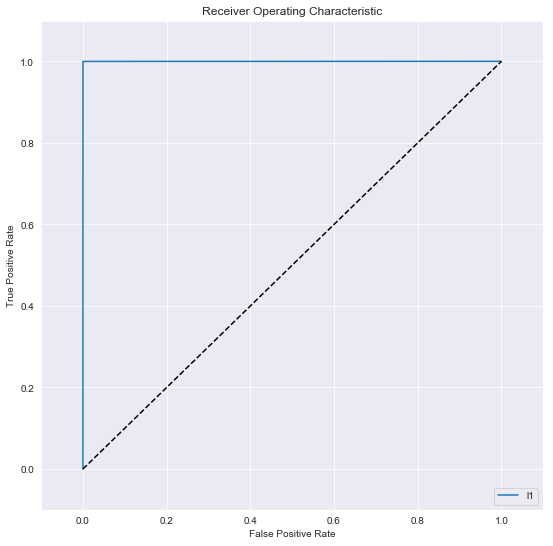

l1 0.999972935382663


/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


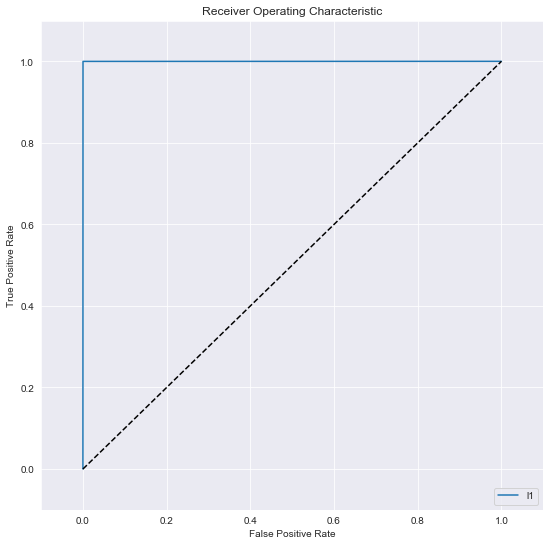

l2 0.9999909647711469


/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


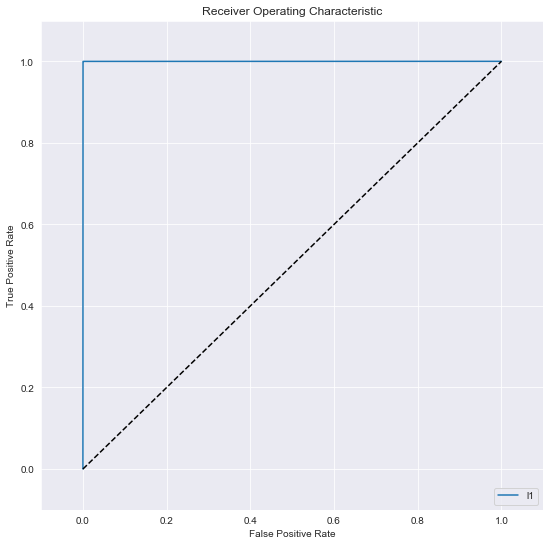

rf 0.9999679264043295


/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


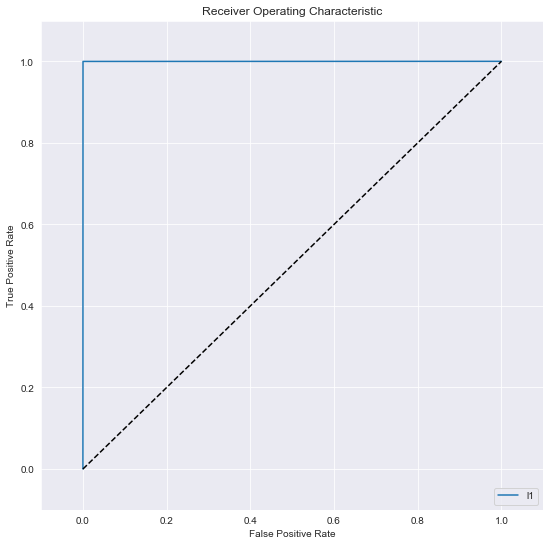

gb 0.9999948751477902


In [27]:
# Predicted positive class probabilites, ROC curves and AUROC for each model
for name, model in fitted_models.items():
    pred = model.predict_proba(X_test)
    pred = [p[1] for p in pred]
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, pred)

    # Plot ROC curve
    fig = plt.figure(figsize=(9,9))
    plt.title('Receiver Operating Characteristic')

    plt.plot(fpr, tpr, label='l1')
    plt.legend(loc='lower right')
    
    plt.plot([0,1],[0,1],'k--')

    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    print( name, roc_auc_score(y_test, pred) )

All of the models performed exceptionally well. Gradient boosting and L2-regularized logistic regression perform best by many decimal places, but L2 has one less false positive. I'll pick L2 as the winner since it performs better (though just very slightly) and since it is a simpler algorithm.

In [28]:
# Save winning model
with open('final_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['l2'].best_estimator_, f)

I'll now load the winning model I just saved to confirm that it saved correctly and works.

In [29]:
# Load winning model
with open('final_model.pkl', 'rb') as f:
    clf = pickle.load(f)

In [30]:
# Display model
print( clf )

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=500, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=123, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])


In [32]:
abt = pd.read_csv('analytical_base_table.csv')

In [33]:
# Split into same train and test sets as before
# Target variable
y = abt.Sex

# Input features
X = abt.drop('Sex', axis=1)

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                          random_state=1234,
                                                    # Stratified random sampling
                                                          stratify=abt.Sex)

In [36]:
# Predict X_test again and print roc_auc_score
pred = clf.predict_proba(X_test)

pred = [p[1] for p in pred]

print( 'AUROC:', roc_auc_score(y_test, pred) )

AUROC: 0.9999909647711469


/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


I'll now write function that compile the data cleaning and features engineering steps for use in future raw data.

In [42]:
def clean_data(df):
    # Drop duplicates
    df.drop_duplicates(inplace=True)
    
    # Drop rows where lifters did not place
    df = df[df.Place != 'DQ']
    df = df[df.Place != 'NS']
    df = df[df.Place != 'DD']
    df = df[df.Place != 'G']
    
    # Drop rows where all 3 lift attempts for any lift are missing
    df = df[df.Squat1Kg.notna() & df.Squat2Kg.notna() & df.Squat3Kg.notna()]
    df = df[df.Bench1Kg.notna() & df.Bench2Kg.notna() & df.Bench3Kg.notna()]
    df = df[df.Deadlift1Kg.notna() & df.Deadlift2Kg.notna() & df.Deadlift3Kg.notna()]

    # Drop unnecessary columns
    df.drop(['Name', 'AgeClass', 'WeightClassKg', 'Division', 'Squat4Kg', 'Bench4Kg', 
             'Deadlift4Kg', 'Place', 'Country', 'Federation', 'Date',
             'MeetCountry', 'MeetState', 'MeetName', 'Event'], axis=1, inplace=True)
    
    # Convert 'Tested' to indicator variable
    df['Tested'] = (df.Tested == 'Yes').astype(int)
    
    # Fill missing values in object columns with 'Missing'
    for column in df.select_dtypes(include=['object']):
        df[column].fillna('Missing', inplace=True)

    # Ad-hoc feature engineering for missed lifts
    lifts = ['Squat1Kg', 'Squat2Kg', 'Squat3Kg',
             'Bench1Kg', 'Bench2Kg', 'Bench3Kg',
             'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg']

    for lift in lifts:
        df[lift + '_missed'] = (df[lift] < 0).astype(int)
    
    # Create Total_missed_lifts feature
    df['Total_missed_lifts'] = df['Squat1Kg_missed'] + df['Squat2Kg_missed'] + df['Squat3Kg_missed'] + df['Bench1Kg_missed'] + df['Bench2Kg_missed'] + df['Bench3Kg_missed'] + df['Deadlift1Kg_missed'] + df['Deadlift2Kg_missed'] + df['Deadlift3Kg_missed']

    # Flag best lifts when missing
    best_lifts = ['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']

    for lift in best_lifts:
        df[lift + '_missing'] = df[lift].isnull().astype(int)
      
    # Change negative numbers to nan
    df.mask(df.select_dtypes(include=['float64']) < 0, other=np.nan, inplace=True)
    
    # Change nan lifts to 0 to indicate a missed lift, which would result in a 0 score
    lifts = ['Squat1Kg', 'Squat2Kg', 'Squat3Kg', 'Best3SquatKg',
             'Bench1Kg', 'Bench2Kg', 'Bench3Kg', 'Best3BenchKg',
             'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg', 'Best3DeadliftKg']
    for lift in lifts:
        df[lift].fillna(0, inplace=True)
    
    # Create indicator variables for missingness in remaining columns
    remaining_columns = ['Age', 'BodyweightKg', 'Wilks', 'McCulloch', 
                     'Glossbrenner', 'IPFPoints']
    for column in remaining_columns:
        df[column + '_missing'] = df[column].isnull().astype(int)
        
    # Fill missing values in remaining numeric features with 0
    for column in remaining_columns:
        df[column].fillna(0, inplace=True)
        
    # Return cleaned dataframe
    return df

In [39]:
def engineer_features(df):
    # Feature engineering code from exploratory analysis
    df.Equipment.replace(['Wraps', 'Straps'], 'Raw', inplace=True)
    df.Equipment.replace(['Single-ply', 'Multi-ply'], 'Equipped', inplace=True)
    
    # Calculate allometric relative strength ratings
    df['Allometric_relative_strength'] = df['TotalKg'] * (df['BodyweightKg']**(-2/3))
    
    # Convert infinite values to nan
    df.Allometric_relative_strength.replace(np.inf, np.nan, inplace=True)
    
    # Create feature to flag missingness
    df['Allometric_relative_strength_missing'] = df.Allometric_relative_strength.isnull().astype(int)
    
    # Now replace nan with 0
    df['Allometric_relative_strength'].fillna(0, inplace=True)
    
    # Create new dataframe with dummy features (excluding target variable)
    df = pd.get_dummies(df, columns=['Equipment'])

    # Return augmented dataframe
    return df

I don't have raw data, but I'll read in the original dataset and drop the target variable to make sure these functions work.

In [55]:
raw_data = pd.read_csv('openpowerlifting.csv')

raw_data.drop('Sex', axis=1, inplace=True)

raw_data.to_csv('raw_data.csv', index=None)

cleaned_data = clean_data(raw_data)
print( cleaned_data.head() )

augmented_data = engineer_features(cleaned_data)
print(augmented_data.head())

  Equipment    Age  BodyweightKg  Squat1Kg  Squat2Kg  Squat3Kg  Best3SquatKg  \
0     Wraps 29.000        59.800    80.000    92.500   105.000       105.000   
1     Wraps 29.000        58.500   100.000   110.000   120.000       120.000   
3     Wraps 23.000        60.000     0.000     0.000   105.000       105.000   
4     Wraps 45.000       104.000   120.000   130.000   140.000       140.000   
5     Wraps 37.000        74.000   127.500   135.000   142.500       142.500   

   Bench1Kg  Bench2Kg  Bench3Kg  Best3BenchKg  Deadlift1Kg  Deadlift2Kg  \
0    45.000    50.000    55.000        55.000      110.000      120.000   
1    55.000    62.500    67.500        67.500      130.000      140.000   
3    67.500    72.500     0.000        72.500      132.500        0.000   
4    70.000    75.000    80.000        80.000      150.000      160.000   
5    72.500    77.500    82.500        82.500      125.000      135.000   

   Deadlift3Kg  Best3DeadliftKg  TotalKg   Wilks  McCulloch  Glossbr

In [47]:
# Predict probabilities
pred = clf.predict_proba(augmented_data)

print( np.round(pred[:5], 4) )

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Now I'll create a class that compiles all of this together.

In [49]:
class PowerlifterGenderModel:
    
    def __init__(self, model_location):
        with open(model_location, 'rb') as f:
            self.model = pickle.load(f)
            
    def predict_proba(self, X_new, clean=True, augment=True):
        if clean:
            X_new = self.clean_data(X_new)
            
        if augment:
            X_new = self.engineer_features(X_new)
            
        return X_new, self.model.predict_proba(X_new)
    
    def clean_data(self, df):
        # Drop duplicates
        df.drop_duplicates(inplace=True)
    
        # Drop rows where lifters did not place
        df = df[df.Place != 'DQ']
        df = df[df.Place != 'NS']
        df = df[df.Place != 'DD']
        df = df[df.Place != 'G']

        # Drop rows where all 3 lift attempts for any lift are missing
        df = df[df.Squat1Kg.notna() & df.Squat2Kg.notna() & df.Squat3Kg.notna()]
        df = df[df.Bench1Kg.notna() & df.Bench2Kg.notna() & df.Bench3Kg.notna()]
        df = df[df.Deadlift1Kg.notna() & df.Deadlift2Kg.notna() & df.Deadlift3Kg.notna()]

        # Drop unnecessary columns
        df.drop(['Name', 'AgeClass', 'WeightClassKg', 'Division', 'Squat4Kg', 'Bench4Kg', 
                 'Deadlift4Kg', 'Place', 'Country', 'Federation', 'Date',
                 'MeetCountry', 'MeetState', 'MeetName', 'Event'], axis=1, inplace=True)

        # Convert 'Tested' to indicator variable
        df['Tested'] = (df.Tested == 'Yes').astype(int)

        # Fill missing values in object columns with 'Missing'
        for column in df.select_dtypes(include=['object']):
            df[column].fillna('Missing', inplace=True)

        # Ad-hoc feature engineering for missed lifts
        lifts = ['Squat1Kg', 'Squat2Kg', 'Squat3Kg',
                 'Bench1Kg', 'Bench2Kg', 'Bench3Kg',
                 'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg']

        for lift in lifts:
            df[lift + '_missed'] = (df[lift] < 0).astype(int)

        # Create Total_missed_lifts feature
        df['Total_missed_lifts'] = df['Squat1Kg_missed'] + df['Squat2Kg_missed'] + df['Squat3Kg_missed'] + df['Bench1Kg_missed'] + df['Bench2Kg_missed'] + df['Bench3Kg_missed'] + df['Deadlift1Kg_missed'] + df['Deadlift2Kg_missed'] + df['Deadlift3Kg_missed']

        # Flag best lifts when missing
        best_lifts = ['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']

        for lift in best_lifts:
            df[lift + '_missing'] = df[lift].isnull().astype(int)

        # Change negative numbers to nan
        df.mask(df.select_dtypes(include=['float64']) < 0, other=np.nan, inplace=True)

        # Change nan lifts to 0 to indicate a missed lift, which would result in a 0 score
        lifts = ['Squat1Kg', 'Squat2Kg', 'Squat3Kg', 'Best3SquatKg',
                 'Bench1Kg', 'Bench2Kg', 'Bench3Kg', 'Best3BenchKg',
                 'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg', 'Best3DeadliftKg']
        for lift in lifts:
            df[lift].fillna(0, inplace=True)

        # Create indicator variables for missingness in remaining columns
        remaining_columns = ['Age', 'BodyweightKg', 'Wilks', 'McCulloch', 
                         'Glossbrenner', 'IPFPoints']
        for column in remaining_columns:
            df[column + '_missing'] = df[column].isnull().astype(int)

        # Fill missing values in remaining numeric features with 0
        for column in remaining_columns:
            df[column].fillna(0, inplace=True)

        # Return cleaned dataframe
        return df

    def engineer_features(self, df):
        # Feature engineering code from exploratory analysis
        df.Equipment.replace(['Wraps', 'Straps'], 'Raw', inplace=True)
        df.Equipment.replace(['Single-ply', 'Multi-ply'], 'Equipped', inplace=True)

        # Calculate allometric relative strength ratings
        df['Allometric_relative_strength'] = df['TotalKg'] * (df['BodyweightKg']**(-2/3))

        # Convert infinite values to nan
        df.Allometric_relative_strength.replace(np.inf, np.nan, inplace=True)

        # Create feature to flag missingness
        df['Allometric_relative_strength_missing'] = df.Allometric_relative_strength.isnull().astype(int)

        # Now replace nan with 0
        df['Allometric_relative_strength'].fillna(0, inplace=True)

        # Create new dataframe with dummy features (excluding target variable)
        df = pd.get_dummies(df, columns=['Equipment'])

        # Return augmented dataframe
        return df

Now to test the class.

In [50]:
# Initialize an instance of the class
powerlifter_model = PowerlifterGenderModel('final_model.pkl')

In [52]:
# Predict raw data
_, pred1 = powerlifter_model.predict_proba(raw_data, clean=True, augment=True)

# Predict cleaned data
_, pred2 = powerlifter_model.predict_proba(cleaned_data, clean=False, augment=True)

# Predict augmented data
_, pred3 = powerlifter_model.predict_proba(augmented_data, clean=False, augment=False)

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [53]:
# Make sure their predictions are all equivalent
np.array_equal(pred1, pred2) and np.array_equal(pred2, pred3)

True

Finally, I'll run the newly made script and check the new 'Predictions' column.

In [59]:
predictions = pd.read_csv('predictions.csv')

predictions.head()

,Age,BodyweightKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Squat1Kg_missed,Squat2Kg_missed,Squat3Kg_missed,Bench1Kg_missed,Bench2Kg_missed,Bench3Kg_missed,Deadlift1Kg_missed,Deadlift2Kg_missed,Deadlift3Kg_missed,Total_missed_lifts,Best3SquatKg_missing,Best3BenchKg_missing,Best3DeadliftKg_missing,Age_missing,BodyweightKg_missing,Wilks_missing,McCulloch_missing,Glossbrenner_missing,IPFPoints_missing,Allometric_relative_strength,Allometric_relative_strength_missing,Equipment_Equipped,Equipment_Raw,Prediction
0,29.000,59.800,80.000,92.500,105.000,105.000,45.000,50.000,55.000,55.000,110.000,120.000,130.000,130.000,290.000,324.160,324.160,286.420,511.150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18.964,0,0,1,0.000
1,29.000,58.500,100.000,110.000,120.000,120.000,55.000,62.500,67.500,67.500,130.000,140.000,145.000,145.000,332.500,378.070,378.070,334.160,595.650,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.064,0,0,1,0.000
2,23.000,60.000,0.000,0.000,105.000,105.000,67.500,72.500,0.000,72.500,132.500,0.000,0.000,132.500,310.000,345.610,345.610,305.370,547.040,0,1,1,0,0,0,1,0,1,1,5,0,0,0,0,0,0,0,0,0,20.227,0,0,1,0.000
3,45.000,104.000,120.000,130.000,140.000,140.000,70.000,75.000,80.000,80.000,150.000,160.000,170.000,170.000,390.000,321.250,338.910,274.560,550.080,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.635,0,0,1,0.000
4,37.000,74.000,127.500,135.000,142.500,142.500,72.500,77.500,82.500,82.500,125.000,135.000,145.000,145.000,370.000,354.740,354.740,312.200,596.180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20.992,0,0,1,0.000


## Insights & Analysis

All of the algorithms I tested performed much better than my original goal. Perhaps there is a clear distinction between male and female lifters that makes them fairly easy to distinguish. All models were essentially winners, but I went with the L2-regularized logistic regression model because it is more simple than the random forest and gradient boosting algorithms. According to the no free lunch theorem, there is no such thing as a "best" algorithm. It just depends on the problem at hand. 

From this project I learned the intricacies of the full data science workflow. I saw a quote from an IBM employee that said data scientists spend about 80% of their time cleaning data and just 20% actually building models. This was true for me in this project. The data cleaning section took a lot of investigating and going back and forth until I felt I had everything set up just right. 

The one thing I wish I had for this project was a new powerlifting dataset to see how the model performs on raw, unseen data. Perhaps in a year or so I can check back and see how much new data has been added to the website.

I acquired this dataset from Kaggle. It is a public dataset shared by openpowerlifting.org.